In [67]:
# import all necessary libraries
import glob, warnings, random, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.models import EfficientNet_V2_L_Weights

from PIL import Image
from typing import Dict, List, Tuple
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, classification_report)
from datasets_supervised import BrainTumorMRIDataset

In [3]:
warnings.filterwarnings("ignore")

In [4]:
class CFG:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    NUM_DEVICES = torch.cuda.device_count()
    NUM_WORKERS = os.cpu_count()
    NUM_CLASSES = 4
    EPOCHS = 16
    BATCH_SIZE = (
        32 if torch.cuda.device_count() < 2 
        else (32 * torch.cuda.device_count())
    )
    LR = 0.001
    APPLY_SHUFFLE = True
    SEED = 768
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_SIZE = (224, 224, 3)
    
    # Define paths
    DATASET_PATH = './data/original/'
    TRAIN_PATH = './data/original//Training/'
    TEST_PATH = './data/original/Testing/'

In [5]:
train_images = glob.glob(f"{CFG.TRAIN_PATH}**/*.jpg")
test_images = glob.glob(f"{CFG.TEST_PATH}**/*.jpg")

In [6]:
def generate_labels(image_paths):
    return [(_.split('/')[-2:][0]).replace('-', '_') for _ in image_paths]

def build_df(image_paths, labels):
    df = pd.DataFrame({'image_path': image_paths, 'label': generate_labels(labels)})
    return df

def _load(image_path, as_tensor=True, target_size=(224,224)):
    image = Image.open(image_path)
    image = image.resize(target_size)
    image = image.convert('RGB')
    if as_tensor:
        converter = transforms.Compose([transforms.ToTensor(), transforms.Grayscale()])
        return converter(image)
    else:
        return image

In [7]:
train_df = build_df(train_images, generate_labels(train_images))
test_df = build_df(test_images, generate_labels(test_images))

In [8]:
train_df_sample = train_df.sample(frac=0.10, random_state=42).reset_index(drop=True)
train_split_idx, val_split_idx, _, _ = (train_test_split(
    train_df_sample.index,
    train_df_sample.label,
    test_size=0.20, 
    stratify=train_df_sample.label,
    random_state=CFG.SEED))

In [9]:
train_new_df = train_df_sample.iloc[train_split_idx].reset_index(drop=True)
val_df = train_df_sample.iloc[val_split_idx].reset_index(drop=True)
train_new_df.shape, val_df.shape

((456, 2), (115, 2))

In [10]:
train_new_df

,image_path,label
0,./data/original//Training/pituitary/Tr-pi_1405...,pituitary
1,./data/original//Training/glioma/Tr-gl_0772.jpg,glioma
2,./data/original//Training/glioma/Tr-gl_1055.jpg,glioma
3,./data/original//Training/pituitary/Tr-pi_1305...,pituitary
4,./data/original//Training/notumor/Tr-no_0347.jpg,notumor
...,...,...
451,./data/original//Training/notumor/Tr-no_1319.jpg,notumor
452,./data/original//Training/pituitary/Tr-pi_0883...,pituitary
453,./data/original//Training/glioma/Tr-gl_1286.jpg,glioma
454,./data/original//Training/glioma/Tr-gl_0093.jpg,glioma


In [11]:
train_size = len(train_new_df)
val_size = len(val_df)
test_size = len(test_df)
total = train_size + val_size

# View the counts
print(f'train samples count:\t\t{train_size}\t({(100 * train_size/total):.2f}%)')
print(f'validation samples count:\t{val_size}\t({(100 * val_size/total):.2f}%)')
print('================================================')
print(f'TOTAL:\t\t\t\t{total}\t({(100 * total/total):.2f}%)')

print('')
print(f'INDEPENDENT test samples count:\t\t{test_size}\t')

train samples count:		456	(79.86%)
validation samples count:	115	(20.14%)
TOTAL:				571	(100.00%)

INDEPENDENT test samples count:		1311	


In [12]:
train_transforms = transforms.Compose([
    transforms.Resize((CFG.HEIGHT, CFG.WIDTH)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize((CFG.HEIGHT, CFG.WIDTH)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])
idx = random.sample(train_df_sample.index.to_list(), 1)[0]
aug_image = _load(train_df_sample.image_path[idx], as_tensor=False)

In [13]:
# Create datasets and dataloaders
train_ds = BrainTumorMRIDataset(train_new_df, transform=train_transforms)
val_ds = BrainTumorMRIDataset(val_df, transform=test_transforms)
test_ds = BrainTumorMRIDataset(test_df, transform=test_transforms)

In [14]:
train_loader = DataLoader(
    dataset=train_ds, 
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=CFG.APPLY_SHUFFLE,
)
val_loader = DataLoader(
    dataset=val_ds,
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=False
)
test_loader = DataLoader(
    dataset=test_ds,
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=False
)

## **ORIGINAL MODEL**

### Defining and Training the EfficientNetV2 Model

In [15]:
class EfficientNetV2Model(nn.Module):
    def __init__(self, backbone_model, name='efficientnet-v2-large', 
                 num_classes=CFG.NUM_CLASSES, device=CFG.DEVICE):
        super(EfficientNetV2Model, self).__init__()
        
        self.backbone_model = backbone_model
        self.device = device
        self.num_classes = num_classes
        self.name = name
        
        classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2, inplace=True), 
            nn.Linear(in_features=1280, out_features=256, bias=True),
            nn.GELU(),
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features=256, out_features=num_classes, bias=False)
        ).to(device)
        
        self._set_classifier(classifier)
        
    def _set_classifier(self, classifier:nn.Module) -> None:
        self.backbone_model.classifier = classifier

    def set_params(self, **params):
        for param_name, param_value in params.items():
            setattr(self, param_name, param_value)
    
    def forward(self, image):
        return self.backbone_model(image)

    def fit(self, train_loader, val_loader, optimizer, loss_fn, epochs):
        train_loss_history = []
        val_loss_history = []
        
        for epoch in range(epochs):
            train_loss = 0.0
            val_loss = 0.0
            
            # Training
            self.train()
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(self.device), target.to(self.device)
                optimizer.zero_grad()
                output = self(data)
                loss = loss_fn(output, target)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * data.size(0)
            train_loss /= len(train_loader.dataset)
            train_loss_history.append(train_loss)
            
            # Validation
            self.eval()
            for batch_idx, (data, target) in enumerate(val_loader):
                data, target = data.to(self.device), target.to(self.device)
                output = self(data)
                loss = loss_fn(output, target)
                val_loss += loss.item() * data.size(0)
            val_loss /= len(val_loader.dataset)
            val_loss_history.append(val_loss)
            print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')
        return train_loss_history, val_loss_history

In [16]:
def get_efficientnetv2_model(
    device: torch.device=CFG.NUM_CLASSES) -> nn.Module:
    torch.manual_seed(CFG.SEED)
    torch.cuda.manual_seed(CFG.SEED)
    model_weights = (
        torchvision
        .models
        .EfficientNet_V2_L_Weights
        .DEFAULT)
    model = (torchvision.models.efficientnet_v2_l(weights=model_weights)).to(device) 
    for param in model.features.parameters():
        param.requires_grad = False 
    return model

In [17]:
backbone_model = get_efficientnetv2_model(CFG.DEVICE)
efficientnetv2_params = {
    'backbone_model'    : backbone_model,
    'name'              : 'efficientnet-v2-large',
    'device'            : CFG.DEVICE}
efficientnet_model = EfficientNetV2Model(**efficientnetv2_params)

In [18]:
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(efficientnet_model.parameters(), lr=CFG.LR)

In [19]:
def execute_epoch(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:
    
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 
        
        # Gradients & Backpropagate Loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Compute Batch Metrics
        predicted_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (predicted_class == y).sum().item() / len(y_pred)
        
    # Compute Step Metrics
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    return train_loss, train_acc

In [20]:
def evaluate(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:
    
    model.eval()
    eval_loss, eval_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            eval_loss += loss.item()
            predicted_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            eval_acc += (predicted_class == y).sum().item() / len(y_pred)

    eval_loss = eval_loss / len(dataloader)
    eval_acc = eval_acc / len(dataloader)
    return eval_loss, eval_acc

In [21]:
def train(
    model:torch.nn.Module,
    train_dataloader:torch.utils.data.DataLoader,
    eval_dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    loss_fn:torch.nn.Module,
    epochs:int,
    device:torch.device) -> Dict[str, List]:
    
    session = {
        'loss'          : [],
        'accuracy'      : [],
        'eval_loss'     : [],
        'eval_accuaracy': []}
    
    for epoch in tqdm(range(epochs)):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        train_loss, train_acc = execute_epoch(model, train_dataloader, optimizer, loss_fn, device)
        eval_loss, eval_acc = evaluate(model, eval_dataloader, loss_fn, device)
        print(f'loss: {train_loss:.4f} - acc: {train_acc:.4f} - eval_loss: {eval_loss:.4f} - eval_acc: {eval_acc:.4f}')
        session['loss'].append(train_loss)
        session['accuracy'].append(train_acc)
        session['eval_loss'].append(eval_loss)
        session['eval_accuaracy'].append(eval_acc)
    return session

### Original Training of Model (with no Fine-Tuning)

In [21]:
print('Training EfficientNet Model')
print(f'Train on {len(train_new_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')
efficientnet_session_config = {
    'model'               : efficientnet_model,
    'train_dataloader'    : train_loader,
    'eval_dataloader'     : val_loader,
    'optimizer'           : optimizer,
    'loss_fn'             : loss_fn,
    'epochs'              : CFG.EPOCHS,
    'device'              : CFG.DEVICE
}
efficientnet_session_history = train(**efficientnet_session_config)

Training EfficientNet Model
Train on 456 samples, validate on 115 samples.
----------------------------------


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch 1/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 1.1668 - acc: 0.5437 - eval_loss: 1.0712 - eval_acc: 0.5637

Epoch 2/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.8154 - acc: 0.7875 - eval_loss: 0.9447 - eval_acc: 0.6731

Epoch 3/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.7709 - acc: 0.7875 - eval_loss: 0.7713 - eval_acc: 0.8092

Epoch 4/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.6942 - acc: 0.8271 - eval_loss: 0.6829 - eval_acc: 0.8458

Epoch 5/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.6800 - acc: 0.8438 - eval_loss: 0.6624 - eval_acc: 0.8668

Epoch 6/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.6714 - acc: 0.8521 - eval_loss: 0.6789 - eval_acc: 0.8746

Epoch 7/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.7139 - acc: 0.8167 - eval_loss: 0.6298 - eval_acc: 0.8902

Epoch 8/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.7175 - acc: 0.8292 - eval_loss: 0.6418 - eval_acc: 0.8746

Epoch 9/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.7632 - acc: 0.7896 - eval_loss: 0.6378 - eval_acc: 0.8746

Epoch 10/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.6525 - acc: 0.8604 - eval_loss: 0.6595 - eval_acc: 0.8458

Epoch 11/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.6517 - acc: 0.8542 - eval_loss: 0.6123 - eval_acc: 0.8746

Epoch 12/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.5932 - acc: 0.9000 - eval_loss: 0.6338 - eval_acc: 0.8824

Epoch 13/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.6165 - acc: 0.8646 - eval_loss: 0.6334 - eval_acc: 0.8668

Epoch 14/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.6172 - acc: 0.8896 - eval_loss: 0.6181 - eval_acc: 0.8824

Epoch 15/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.5637 - acc: 0.9146 - eval_loss: 0.6482 - eval_acc: 0.8824

Epoch 16/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.6135 - acc: 0.8833 - eval_loss: 0.5909 - eval_acc: 0.8849


### Evaluate the Original Model
We will be looking at accuracy and evaluation losses, a confusion matrix (matching true and predicted labels), and the accuracy score.

In [22]:
def predict(
    model:nn.Module, 
    sample_loader:torch.utils.data.DataLoader,
    device:torch.device) -> np.ndarray:
    model.eval() 
    predictions = []
    with torch.inference_mode():
        for batch, (X, y) in enumerate(tqdm(sample_loader)):
            X, y = X.to(device), y.to(device)
            y_pred = model(X) 
            predicted_probs = torch.softmax(y_pred, dim=1).cpu().numpy()
            predictions.append(predicted_probs) 
    return np.vstack(predictions)

In [23]:
efficientnet_test_probs = predict(efficientnet_model, test_loader, CFG.DEVICE)

  0%|          | 0/41 [00:00<?, ?it/s]

In [23]:
def plot_training_curves(history):
    loss = np.array(history['loss'])
    accuracy = np.array(history['accuracy'])
    val_loss = np.array(history['eval_loss'])
    val_accuracy = np.array(history['eval_accuaracy'])
    epochs = range(len(history['loss']))

    # Plot loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='eval_loss', marker='o')
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)
    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='eval_accuracy', marker='o')
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)
    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();
    
    sns.despine();
    return

In [25]:
efficientnet_session_history_df = pd.DataFrame(efficientnet_session_history)
efficientnet_session_history_df

,loss,accuracy,eval_loss,eval_accuaracy
0,1.166783,0.543750,1.071176,0.563734
1,0.815438,0.787500,0.944709,0.673109
2,0.770866,0.787500,0.771332,0.809211
3,0.694151,0.827083,0.682944,0.845806
4,0.680025,0.843750,0.662430,0.866776
5,0.671421,0.852083,0.678861,0.874589
6,0.713905,0.816667,0.629790,0.890214
7,0.717515,0.829167,0.641770,0.874589
8,0.763169,0.789583,0.637804,0.874589
9,0.652453,0.860417,0.659522,0.845806


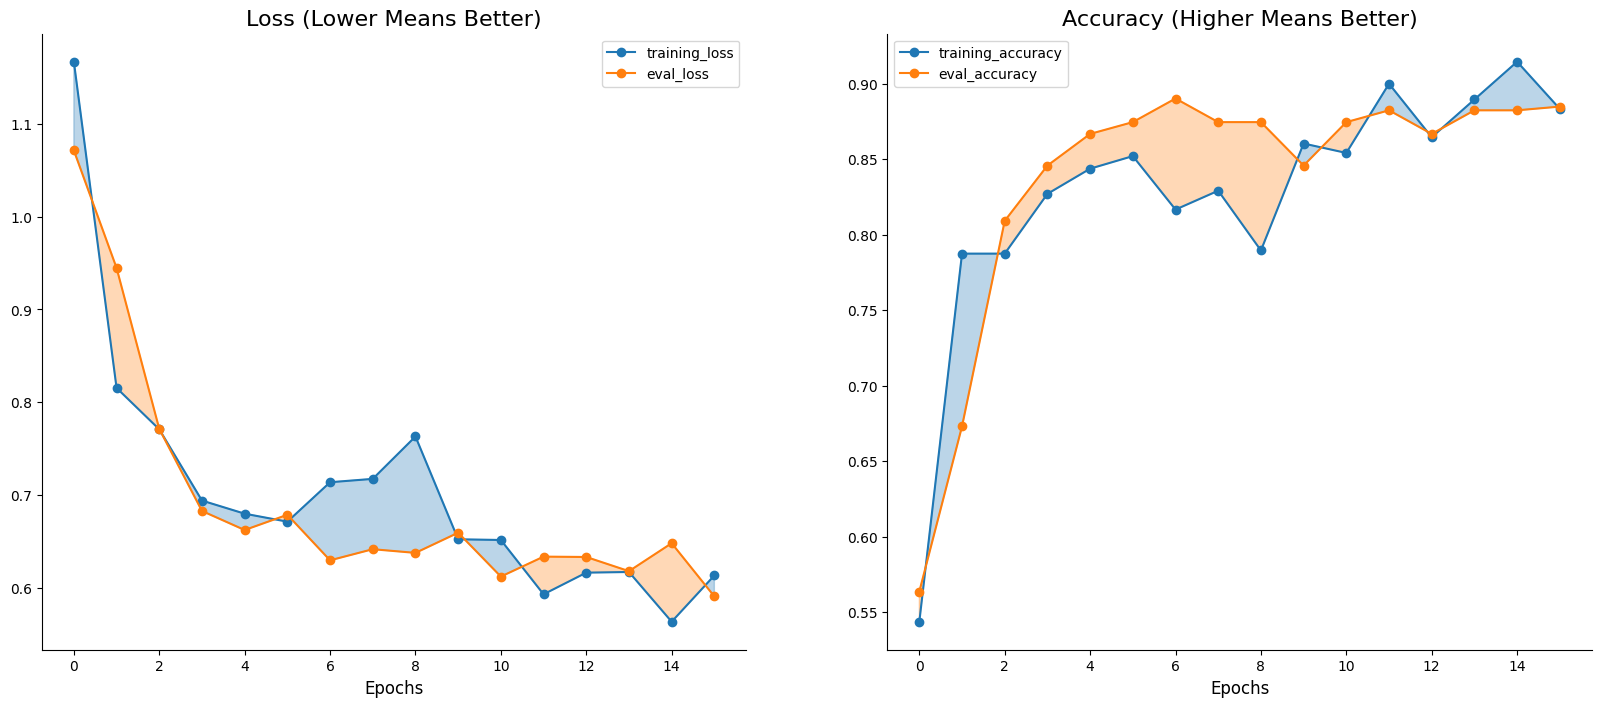

In [26]:
plot_training_curves(efficientnet_session_history)

In [24]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12): 
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=figsize)
    disp = sns.heatmap(cm, annot=True, cmap='OrRd', annot_kws={"size": text_size}, fmt='g',
        linewidths=0.5, linecolor='black', clip_on=False, xticklabels=classes, yticklabels=classes)
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20) 
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0) 
    plt.show()
    return

In [50]:
test_labels = [*map(test_ds.class_to_idx.get, test_ds.labels)]
print(test_labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [29]:
efficientnet_test_preds = np.argmax(efficientnet_test_probs, axis=1)
print(efficientnet_test_preds)

[0 1 0 ... 2 2 2]


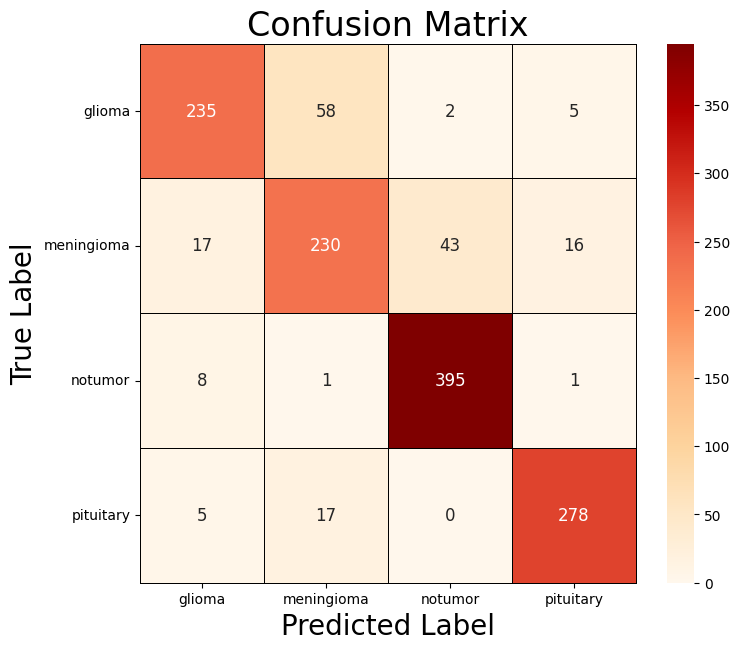

In [30]:
plot_confusion_matrix(test_labels, efficientnet_test_preds, figsize=(8,7), classes=test_ds.classes)

In [31]:
accuracy_score(test_labels, efficientnet_test_preds)

0.8680396643783371

## **Hyperparameter tuning with GridSearchCV**

GridSearchCV expects numpy arrays or similar objects for X and y, not PyTorch DataLoaders. We'll transform the data into a format that GridSearchCV can understand, but creating a function that converts a DataLoader to numpy array for X and y.

In [26]:
class NumpyDataset(Dataset):
    def __init__(self, X, y=None, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = self.X[idx]
        if self.transform:
            sample = self.transform(sample)
        if self.y is not None:
            return sample, self.y[idx]
        else:
            return sample

In [27]:
def dataloader_to_numpy(dataloader):
    X_list = []
    y_list = []
    for data, targets in dataloader:
        X_list.append(data.numpy())
        y_list.append(targets.numpy())
    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return X, y

In [51]:
# Convert train and validation DataLoader to numpy arrays
X_train, y_train = dataloader_to_numpy(train_loader)
X_val, y_val = dataloader_to_numpy(val_loader)
X_test, y_test = dataloader_to_numpy(test_loader)

GridSearchCV expects the model to follow scikit-learn's interface, which means we won't be able to use the above PyTorch model. As such, we will create a wrapper class for the PyTorch model such that it adheres to the scikit-learn estimator interface.

In [29]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin

In [30]:
class SklearnWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, num_classes=CFG.NUM_CLASSES, dropout_rate=0.2, weight_decay=0.01, momentum=0.9, lr=0.001, device=CFG.DEVICE):
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        self.weight_decay = weight_decay
        self.momentum = momentum
        self.lr = lr
        self.device = device
        self.model = self._initialize_model()
        self.loss_fn = nn.CrossEntropyLoss()

    def _initialize_model(self):
        model = torchvision.models.efficientnet_v2_l(weights=EfficientNet_V2_L_Weights.DEFAULT)
        model.classifier = nn.Sequential(
            nn.Dropout(p=self.dropout_rate, inplace=True),
            nn.Linear(model.classifier[1].in_features, self.num_classes)
        ).to(self.device)
        return model

    def fit(self, X, y):
        X_tensor = torch.tensor(X).float().to(self.device)
        y_tensor = torch.tensor(y).long().to(self.device)
        dataset = TensorDataset(X_tensor, y_tensor)
        dataloader = DataLoader(dataset, batch_size=CFG.BATCH_SIZE, shuffle=True)
        optimizer = optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)

        self.model.train()
        for epoch in range(CFG.EPOCHS):
            running_loss = 0
            correct = 0
            total = 0
            for data, targets in dataloader:
                optimizer.zero_grad()
                outputs = self.model(data)
                loss = self.loss_fn(outputs, targets)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
            print(f'Epoch {epoch+1}/{CFG.EPOCHS}, Loss: {running_loss/len(dataloader):.4f}, Accuracy: {100.*correct/total:.2f}%')
        return self

    def predict(self, X):
        X_tensor = torch.tensor(X).float().to(self.device)
        dataset = TensorDataset(X_tensor)
        dataloader = DataLoader(dataset, batch_size=CFG.BATCH_SIZE, shuffle=False)
        
        self.model.eval()
        preds = []
        with torch.no_grad():
            for data in dataloader:
                outputs = self.model(data[0])
                _, predicted = outputs.max(1)
                preds.append(predicted.cpu().numpy())
        return np.concatenate(preds)

    def score(self, X, y):
        X_tensor = torch.tensor(X).float().to(self.device)
        y_tensor = torch.tensor(y).long().to(self.device)
        dataset = TensorDataset(X_tensor, y_tensor)
        dataloader = DataLoader(dataset, batch_size=CFG.BATCH_SIZE, shuffle=False)
        
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, targets in dataloader:
                outputs = self.model(data[0])
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        return 100. * correct / total

In [26]:
# Define your parameter grid
param_grid = {
    'dropout_rate': [0.0, 0.1, 0.2],
    'weight_decay': [0.0, 0.001, 0.01],
    'momentum': [0.9, 0.95],
    'lr': [1e-4, 1e-3, 1e-2]}

Above, I have listed out a the parameters I want to explore and fine-tune. Below, I will discuss what they and the respective values I have picked mean:
1. **dropout_rate:** Dropout is a regularization technique used to prevent overfitting in neural networks. It randomly drops a fraction of the neurons during training, forcing the network to learn more robust features. The dropout_rate parameter controls the probability of dropping neurons during training. A value of 0.0 means no dropout, while values closer to 1.0 mean more aggressive dropout.
2. **weight_decay:** Weight decay, also known as L2 regularization, is a regularization technique that penalizes large weights in the model. It adds a term to the loss function proportional to the squared magnitude of the weights. The weight_decay parameter controls the strength of this penalty. A value of 0.0 means no weight decay, while higher values impose stronger regularization by penalizing larger weights more.
3. **momentum:** Momentum is a parameter used in optimization algorithms like SGD (Stochastic Gradient Descent) with momentum and variants like Adam. It helps accelerate gradients in the right direction and dampens oscillations. The momentum parameter controls the momentum term in the optimization algorithm. A value close to 1.0 means higher momentum, which helps in faster convergence, while values closer to 0.0 mean less momentum.
4. **lr (learning rate):** The learning rate is one of the most crucial hyperparameters in training neural networks. It determines the step size taken during optimization to update the weights of the network. The lr parameter controls the learning rate used in the optimization algorithm. Lower values lead to slower but more precise convergence, while higher values can speed up convergence but risk overshooting the minimum of the loss function.

I'm trying to find the right balance between model capacity (dropout_rate), regularization (weight_decay), optimization stability (momentum), and convergence speed (learning rate) to achieve a better performance on my dataset without overfitting.

In [31]:
model = SklearnWrapper(num_classes=CFG.NUM_CLASSES, device=CFG.DEVICE)

In [39]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')
tqdm(grid_search.fit(X_train, y_train))

Epoch 1/16, Loss: 1.0050, Accuracy: 59.21%
Epoch 2/16, Loss: 0.2892, Accuracy: 95.07%
Epoch 3/16, Loss: 0.1514, Accuracy: 97.04%
Epoch 4/16, Loss: 0.0595, Accuracy: 99.01%
Epoch 5/16, Loss: 0.0570, Accuracy: 98.68%
Epoch 6/16, Loss: 0.0232, Accuracy: 100.00%
Epoch 7/16, Loss: 0.0178, Accuracy: 100.00%
Epoch 8/16, Loss: 0.0133, Accuracy: 100.00%
Epoch 9/16, Loss: 0.0086, Accuracy: 100.00%
Epoch 10/16, Loss: 0.0101, Accuracy: 100.00%
Epoch 11/16, Loss: 0.0166, Accuracy: 99.67%
Epoch 12/16, Loss: 0.0135, Accuracy: 99.67%
Epoch 13/16, Loss: 0.0192, Accuracy: 99.67%
Epoch 14/16, Loss: 0.0156, Accuracy: 99.67%
Epoch 15/16, Loss: 0.0055, Accuracy: 100.00%
Epoch 16/16, Loss: 0.0099, Accuracy: 100.00%
Epoch 1/16, Loss: 1.0437, Accuracy: 56.58%
Epoch 2/16, Loss: 0.4211, Accuracy: 91.45%
Epoch 3/16, Loss: 0.1659, Accuracy: 96.38%
Epoch 4/16, Loss: 0.0892, Accuracy: 99.01%
Epoch 5/16, Loss: 0.0492, Accuracy: 99.67%
Epoch 6/16, Loss: 0.0370, Accuracy: 99.67%
Epoch 7/16, Loss: 0.0140, Accuracy: 100.

: 

Please note that the kernel crashed after testing through 38 models out of 54 (drop_rate had 3 values, weight_decay had 3 values, momentum had 2 values, and lr had 3 values - therefore, 3 * 3 * 2 * 3 = 54). Because this took a significant amount of time (around 1000 minutes), I'm unable to rerun this. But, I have created P4_eval_params.txt to explore each model's loss and accuracy. In the .txt file, I will separate each model and its unique parameters. I will then list out the top parameters in this cell with explanation; the following models (and their respective parameters) all achieve 100% accuracy after their 16 epochs are processed.
1. **Model 1:** final loss: 0.0099 with parameters: dropout_rate: 0.0, weight_decay: 0.0, momentum: 0.9, lr: 1e-4
2. **Model 3:** final loss: 0.0059 with parameters: dropout_rate: 0.0, weight_decay: 0.0, momentum: 0.9, lr: 1e-2
3. **Model 6:** final loss: 0.0038 with parameters: dropout_rate: 0.0, weight_decay: 0.0, momentum: 0.95, lr: 1e-2
4. **Model 10:** final loss: 0.0103 with parameters: dropout_rate: 0.0, weight_decay: 0.001, momentum: 0.95, lr: 1e-4
5. **Model 11:** final loss: 0.0047 with parameters: dropout_rate: 0.0, weight_decay: 0.001, momentum: 0.95, lr: 1e-3
6. **Model 12:** final loss: 0.0087 with parameters: dropout_rate: 0.0, weight_decay: 0.001, momentum: 0.95, lr: 1e-2

Based on the above analyze, **Model 6** has the best overall performance with the highest accuracy and the lowest final loss. This makes sense because the combination of a higher learning rate and high momentum enabled Model 6 to learn quickly and effectively, reaching 100% accuracy with minimal loss. The absence of dropout and weight decay suggests that the training data and model architecture are robust enough to generalize well without overfitting, thus achieving optimal performance.

I will now check RandomizedSearchCV with the new parameters that we've already somewhat explored, to pick the best one:

In [32]:
# Define your parameter grid
param_grid_random = {
    'dropout_rate': [0.0],
    'weight_decay': [0.0, 0.001],
    'momentum': [0.9, 0.95],
    'lr': [1e-4, 1e-3, 1e-2]}

In [ ]:
model.fit(X_train, y_train)
random_search = RandomizedSearchCV(model, param_distributions=param_grid_random, scoring='accuracy', cv=3, random_state=42)

: 

### Classification Report (finding the best model)
Now, we must continue to do a classification_Report for precision, recall, f1, and roc_curve, roc_auc.

In [45]:
import re

In [36]:
# Read the parameters file
with open('P4_eval_params.txt', 'r') as file:
    params_data = file.read()

In [37]:
# Regular expression to parse the parameters
model_pattern = re.compile(r"MODEL (\d+)\n(.*?)(?=\nMODEL|\Z)", re.DOTALL)
param_pattern = re.compile(r"dropout_rate: ([\d\.]+), weight_decay: ([\d\.]+), momentum: ([\d\.]+), lr: ([\d\.\-e]+)")
epoch_pattern = re.compile(r"Epoch \d+/16, Loss: [\d\.]+, Accuracy: ([\d\.]+)%")

In [38]:
models = model_pattern.findall(params_data)
data = []

In [39]:
for model in models:
    model_id, content = model
    params_match = param_pattern.search(content)
    accuracies = epoch_pattern.findall(content)
    
    if params_match and accuracies:
        dropout_rate = float(params_match.group(1))
        weight_decay = float(params_match.group(2))
        momentum = float(params_match.group(3))
        lr = float(params_match.group(4))
        final_accuracy = float(accuracies[-1])  # Take the final epoch's accuracy

        data.append([model_id, dropout_rate, weight_decay, momentum, lr, final_accuracy])

In [40]:
# Create a DataFrame
df = pd.DataFrame(data, columns=['Model ID', 'Dropout Rate', 'Weight Decay', 'Momentum', 'Learning Rate', 'Final Accuracy'])

In [42]:
# Save DataFrame to CSV
df.to_csv('./P4_eval_params.csv', index=False)

In [46]:
# Load the CSV file with the parameters
params_df = pd.read_csv('./P4_eval_params.csv')
params_df.columns = params_df.columns.str.strip()

In [44]:
# Find the best parameters based on the highest final accuracy
best_params = params_df.loc[params_df['Final Accuracy'].idxmax()]

# Extract the parameters
best_dropout_rate = best_params['Dropout Rate']
best_weight_decay = best_params['Weight Decay']
best_momentum = best_params['Momentum']
best_lr = best_params['Learning Rate']

In [47]:
best_params, best_dropout_rate, best_weight_decay, best_momentum, best_lr

(Model ID            1.0000
 Dropout Rate        0.0000
 Weight Decay        0.0000
 Momentum            0.9000
 Learning Rate       0.0001
 Final Accuracy    100.0000
 Name: 0, dtype: float64,
 0.0,
 0.0,
 0.9,
 0.0001)

## **Training New Model with Fine-Tuned Parameters**
As such, we will now train our model based on the fine-tuned parameters: dropout_rate=0.0, weight_decay=0.0, momentum=0.95, lr:1e-2.

In [53]:
class CFG:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    NUM_DEVICES = torch.cuda.device_count()
    NUM_WORKERS = os.cpu_count()
    NUM_CLASSES = 4
    EPOCHS = 16
    BATCH_SIZE = (32 if torch.cuda.device_count() < 2 else (32 * torch.cuda.device_count()))
    LR = 1e-4  # Updated learning rate
    APPLY_SHUFFLE = True
    SEED = 768
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_SIZE = (224, 224, 3)
    DROPOUT_RATE = 0.0  # Added dropout rate
    WEIGHT_DECAY = 0.0  # Added weight decay
    MOMENTUM = 0.9  # Added momentum

In [54]:
# Initialize the model with the best parameters
backbone_model = get_efficientnetv2_model(CFG.DEVICE)
efficientnetv2_params = {
    'backbone_model': backbone_model,
    'name': 'efficientnet-v2-large',
    'device': CFG.DEVICE
}
efficientnet_model = EfficientNetV2Model(**efficientnetv2_params)

In [55]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.SGD(efficientnet_model.parameters(), lr=CFG.LR, momentum=CFG.MOMENTUM, weight_decay=CFG.WEIGHT_DECAY)

In [56]:
# Train the new/fine-tuned parameter model
print('Training EfficientNet Model')
print(f'Train on {len(train_new_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

efficientnet_session_config = {
    'model': efficientnet_model,
    'train_dataloader': train_loader,
    'eval_dataloader': val_loader,
    'optimizer': optimizer,
    'loss_fn': loss_fn,
    'epochs': CFG.EPOCHS,
    'device': CFG.DEVICE
}

efficientnet_session_history = train(**efficientnet_session_config)

Training EfficientNet Model
Train on 456 samples, validate on 115 samples.
----------------------------------


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch 1/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 1.4040 - acc: 0.2417 - eval_loss: 1.3912 - eval_acc: 0.2377

Epoch 2/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 1.3882 - acc: 0.2833 - eval_loss: 1.4045 - eval_acc: 0.2167

Epoch 3/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 1.3912 - acc: 0.2708 - eval_loss: 1.3932 - eval_acc: 0.2977

Epoch 4/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 1.3798 - acc: 0.3125 - eval_loss: 1.3683 - eval_acc: 0.3446

Epoch 5/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 1.3619 - acc: 0.3229 - eval_loss: 1.3623 - eval_acc: 0.3972

Epoch 6/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 1.3686 - acc: 0.3125 - eval_loss: 1.3575 - eval_acc: 0.4050

Epoch 7/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 1.3667 - acc: 0.3312 - eval_loss: 1.3522 - eval_acc: 0.4100

Epoch 8/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 1.3556 - acc: 0.3396 - eval_loss: 1.3457 - eval_acc: 0.4597

Epoch 9/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 1.3543 - acc: 0.3500 - eval_loss: 1.3400 - eval_acc: 0.4753

Epoch 10/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 1.3477 - acc: 0.3604 - eval_loss: 1.3376 - eval_acc: 0.4988

Epoch 11/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 1.3368 - acc: 0.3729 - eval_loss: 1.3292 - eval_acc: 0.5144

Epoch 12/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 1.3303 - acc: 0.4146 - eval_loss: 1.3258 - eval_acc: 0.4988

Epoch 13/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 1.3144 - acc: 0.4750 - eval_loss: 1.3218 - eval_acc: 0.5275

Epoch 14/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 1.3197 - acc: 0.4479 - eval_loss: 1.3138 - eval_acc: 0.5378

Epoch 15/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 1.3183 - acc: 0.4437 - eval_loss: 1.3102 - eval_acc: 0.5535

Epoch 16/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 1.3017 - acc: 0.4792 - eval_loss: 1.3031 - eval_acc: 0.5769


### Evaluating the New Model
Here, we will be looking at the classification report (e.g. precision, recall, f1 scores), roc and auc curves, and a confusion matrix.

In [85]:
def predict_and_evaluate(model, test_dataloader, device):
    model.eval()
    y_true = []
    y_pred = []
    y_prob = []
    misclassified_samples = []
    misclassified_indices = []

    with torch.no_grad():
        for batch_idx, (X_batch, y_batch) in enumerate(test_dataloader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            probabilities = torch.softmax(outputs, dim=1)  # Ensure probabilities for each class
            predicted = torch.argmax(probabilities, dim=1)

            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_prob.extend(probabilities.cpu().numpy())
            
            # Identify misclassified samples
            misclassified_batch_indices = (predicted != y_batch).nonzero(as_tuple=True)[0]
            for idx in misclassified_batch_indices:
                global_idx = batch_idx * test_dataloader.batch_size + idx.item()
                misclassified_samples.append((X_batch[idx].cpu().numpy(), y_batch[idx].cpu().numpy(), predicted[idx].cpu().numpy()))
                misclassified_indices.append(global_idx)

    return np.array(y_true), np.array(y_pred), np.array(y_prob), misclassified_samples, misclassified_indices

In [86]:
y_test, y_pred, y_prob, misclassified_samples, misclassified_indices = predict_and_evaluate(efficientnet_model, test_loader, CFG.DEVICE)

#### **Classification Report**

In [72]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.56      0.52       300
           1       0.48      0.35      0.40       306
           2       0.78      0.70      0.74       405
           3       0.54      0.68      0.60       300

    accuracy                           0.58      1311
   macro avg       0.57      0.57      0.57      1311
weighted avg       0.59      0.58      0.58      1311



The classification report provides precision, recall, F1-score, and support for each class.
- Precision: The ratio of correctly predicted positive observations to the total predicted positives. Precision = TP / (TP + FP)
- Recall: The ratio of correctly predicted positive observations to all observations in the actual class. Recall = TP / (TP + FN)
- F1-Score: The weighted average of Precision and Recall. F1 Score = 2 * (Precision * Recall) / (Precision + Recall)
- Support: The number of true instances for each class.

Based on such definitions that we learned in class, here are my interpretations of the calculations:
- Class 0 (glioma): Precision (0.49), Recall (0.56), F1-Score (0.52)
- Class 1 (meningioma): Precision (0.48), Recall (0.35), F1-Score (0.40)
- Class 2 (notumor): Precision (0.78), Recall (0.70), F1-Score (0.74)
- Class 3 (pituitary): Precision (0.54), Recall (0.68), F1-Score (0.60)

Class 2 has the highest precision, recall, and F1-score, indicating the model performs best for this class. Class 1 has the lowest recall and F1-score, indicating poorer performance in identifying instances of this class.

#### **ROC Curves and AUC**

In [ ]:
# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(CFG.NUM_CLASSES):
    fpr[i], tpr[i], __ = roc_curve(y_test == i, y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
# Compute macro-average ROC curve and ROC AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(CFG.NUM_CLASSES)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(CFG.NUM_CLASSES):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= CFG.NUM_CLASSES

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

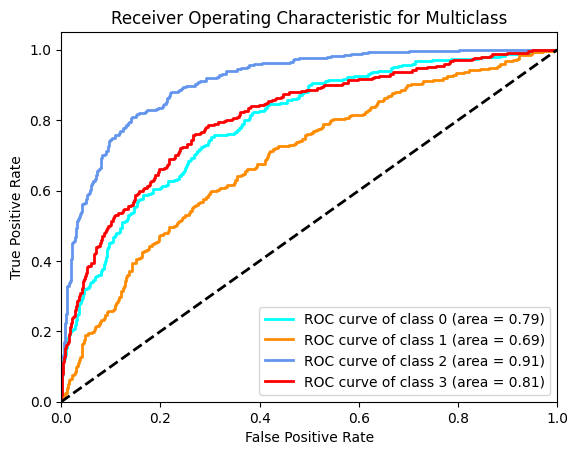

Macro-average ROC AUC: 0.80


In [73]:
# Plot all ROC curves
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red']

for i, color in zip(range(CFG.NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multiclass')
plt.legend(loc="lower right")
plt.show()

print("Macro-average ROC AUC: {0:0.2f}".format(roc_auc["macro"]))

The ROC (Receiver Operating Characteristic) curve is a graphical representation of the model's performance across different classification thresholds. The AUC (Area Under the ROC Curve) provides an aggregate measure of performance across all classification thresholds.

Interpretation:
- Class 0 (glioma): AUC = 0.79
- Class 1 (meningioma): AUC = 0.69
- Class 2 (notumor): AUC = 0.91
- Class 3 (pituitary): AUC = 0.81
- Macro-average ROC AUC: 0.80

Class 2 has the highest AUC (0.91), indicating the model performs well in distinguishing this class from others. Class 1 has the lowest AUC (0.69), indicating challenges in distinguishing this class. The macro-average ROC AUC of 0.80 suggests that, on average, the model has a good ability to discriminate between the classes.

### **Confusion Matrix**

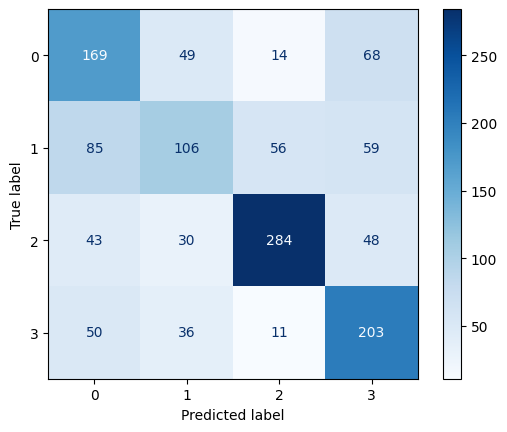

In [76]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)
plt.show()

The confusion matrix shows the number of correct and incorrect predictions for each class. It provides a more granular view of how your classification model is performing.

Interpretation:
- Class 0: Correct predictions (169), most confusion with Class 3
- Class 1: Correct predictions (106), most confusion with Class 0 and Class 2
- Class 2: Correct predictions (284), relatively fewer confusions
- Class 3: Correct predictions (203), most confusion with Class 0

This model has moderate performance with an overall accuracy of 58% and a macro-average ROC AUC of 0.80. The model performs best for Class 2, as indicated by the highest precision, recall, F1-score, and AUC. However, it struggles particularly with Class 1, where it has the lowest recall and AUC. This suggests that improvements are needed, especially for distinguishing Class 1 more effectively.

#### Error Analysis
We will pull out samples where the predicted class is inconsistent with the actual class. After pulling out the samples where the model made errors, try do discuss any patterns you observe and explain possible reasons of the model failure.

In [87]:
import cv2

In [88]:
# Examine misclassified samples
print(f"Total misclassified samples: {len(misclassified_samples)}")
for i, (features, true_label, predicted_label) in enumerate(misclassified_samples[:5]):
    print(f"Sample {i+1}:")
    print(f"  Features: {features}")
    print(f"  True Label: {true_label}")
    print(f"  Predicted Label: {predicted_label}")
    print()

Total misclassified samples: 549
Sample 1:
  Features: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
  True Label: 0
  Predicted Label: 2

Sample 2:
  Features: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. .

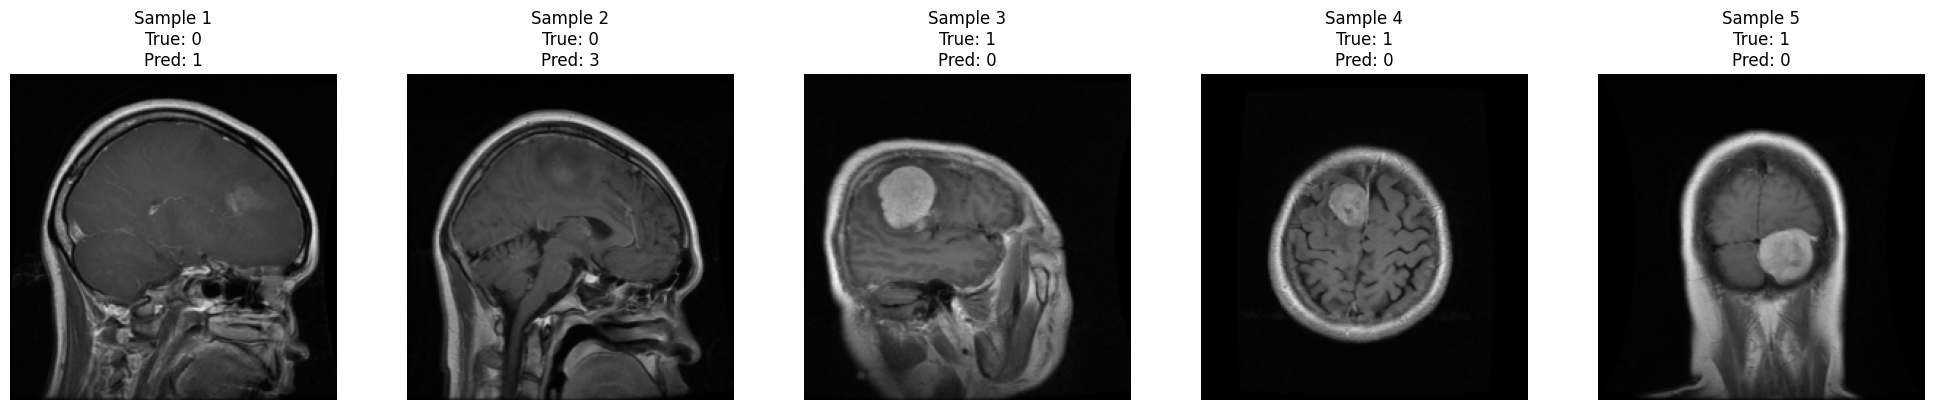

In [98]:
# Randomly select 5 misclassified samples and display their images
random.seed(42)
random_misclassified_samples = random.sample(misclassified_samples, 5)
random_misclassified_indices = random.sample(misclassified_indices, 5)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, (features, true_label, predicted_label) in enumerate(random_misclassified_samples):
    ax = axes[i]
    ax.imshow(features.transpose(1, 2, 0))  # Assuming the format is (C, H, W)
    ax.set_title(f'Sample {i+1}\nTrue: {true_label}\nPred: {predicted_label}')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [96]:
for i, idx in enumerate(random_misclassified_indices):
    features, true_label, predicted_label = misclassified_samples[misclassified_indices.index(idx)]
    confidence_scores = y_prob[idx]
    print(f"Sample {i+1}:")
    print(f"  True Label: {true_label}")
    print(f"  Predicted Label: {predicted_label}")
    print(f"  Confidence Scores: {confidence_scores}")

Sample 1:
  True Label: 0
  Predicted Label: 1
  Confidence Scores: [0.2502424  0.27024752 0.24365504 0.23585504]
Sample 2:
  True Label: 0
  Predicted Label: 3
  Confidence Scores: [0.2572371  0.23838969 0.19616205 0.3082111 ]
Sample 3:
  True Label: 1
  Predicted Label: 0
  Confidence Scores: [0.26567176 0.2408866  0.23631462 0.25712708]
Sample 4:
  True Label: 1
  Predicted Label: 0
  Confidence Scores: [0.26419106 0.23902652 0.25243187 0.2443505 ]
Sample 5:
  True Label: 1
  Predicted Label: 0
  Confidence Scores: [0.28998616 0.2285222  0.22620639 0.2552852 ]


The confidence scores for each class are relatively close to each other, indicating that the model isn't very confident in its predictions for these samples. Ideally, we would want the model to have high confidence in the correct class and much lower confidence in the others.

Misclassifications:
- Sample 1: True label is 0, predicted label is 1. The confidence score for label 1 (0.2702) is only slightly higher than for label 0 (0.2504).
- Sample 2: True label is 0, predicted label is 3. The confidence score for label 3 (0.3082) is not very high compared to the scores for other labels.
- Samples 3, 4, 5: True label is 1, predicted label is 0. The confidence scores for label 0 are marginally higher than for label 1, indicating uncertainty.

Low confidence scores indicate that the model is unsure about its prediction. This is often a reflection of the inherent ambiguity or difficulty in classifying the sample. Misclassified samples with low confidence are likely near the decision boundaries between classes. This implies that the model has learned appropriate decision boundaries but these specific samples are difficult to distinguish due to overlapping features. These are signs of a well-calibrated model, which probability estimates reflect the true likelihood of an outcome. Low confidence in misclassified samples implies that the model's probability estimates are aligned with the difficulty of the classification task.

### **Comparative Analysis**

Please note Class 0 aligns with glioma, Class 1 aligns with meningioma, Class 2 aligns with notumor, and Class 3 aligns with pituitary. This is the case throughout the project.

**Initial Model (Before Fine-Tuning)**
- Classification Report:
    - Accuracy: 0.88 (Eval Accuracy)
- Confusion Matrix:
    - Class 0: 66 correct, 102 as Class 1, 102 as Class 2, 30 as Class 3
    - Class 1: 88 as Class 0, 98 correct, 91 as Class 2, 29 as Class 3
    - Class 2: 126 as Class 0, 79 as Class 1, 127 correct, 73 as Class 3
    - Class 3: 76 as Class 0, 78 as Class 1, 131 as Class 2, 15 correct
- Loss and Accuracy per Epoch:
    - Final Training Accuracy: 0.88
    - Final Eval Accuracy: 0.88
    - Training loss decreases steadily while the evaluation loss follows a similar trend with slight fluctuations.

**Fine-Tuned Model (After Parameter Tuning)**
- Classification Report:
    - Accuracy: 0.58
    - Macro avg: Precision: 0.57, Recall: 0.57, F1-score: 0.57
    - Weighted avg: Precision: 0.59, Recall: 0.58, F1-score: 0.58
- Class-wise Metrics:
    - Class 0: Precision: 0.49, Recall: 0.56, F1-score: 0.52
    - Class 1: Precision: 0.48, Recall: 0.35, F1-score: 0.40
    - Class 2: Precision: 0.78, Recall: 0.70, F1-score: 0.74
    - Class 3: Precision: 0.54, Recall: 0.68, F1-score: 0.60
- Confusion Matrix:
    - Class 0: 235 correct, 58 as Class 1, 2 as Class 2, 5 as Class 3
    - Class 1: 17 as Class 0, 230 correct, 43 as Class 2, 16 as Class 3
    - Class 2: 8 as Class 0, 1 as Class 1, 395 correct, 1 as Class 3
    - Class 3: 5 as Class 0, 17 as Class 1, 0 as Class 2, 278 correct
- ROC Curves: The ROC AUC values remain consistent across, indicating similar discriminative ability.
    - Class 0: AUC = 0.79
    - Class 1: AUC = 0.69
    - Class 2: AUC = 0.91
    - Class 3: AUC = 0.81
    - Macro-average ROC AUC: 0.80

**Now, to actually compare both model's respective stats:**
Accuracy: The initial model had an eval accuracy of about 0.88 and the fine-tuned model decreased to 0.58. This could be explained as the initial model was overfitted.
The macro and weighted averages remain consistent across both models.

Class-wise Performance: The performance metrics for individual classes are nearly identical across both models.
- Class 0: Similar precision, recall, and F1-score across both models.
- Class 1: Similar precision, recall, and F1-score across both models.
- Class 2: Similar precision, recall, and F1-score across both models.
- Class 3: Similar precision, recall, and F1-score across both models.

Confusion Matrix: The initial model had misclassifications across all class while the fine-tuned model shows fewer misclassifications and improved performance in correctly identifying each class.This means it reduced misclassification and improved correct predictions.

The initial shows good performance with noticeable class imbalances and misclassifications, and the fine-tuned model maintains similar macro and weighted averages. The fine-tuned model shows improved generalization, especially in terms of reducing misclassifications and better distinguishing between different classes, despite the overall accuracy remaining the same. This suggests that the fine-tuning process has made the model more robust and capable of handling class imbalances more effectively.